**cuDisc plotting example notebook**

This notebook shows how to use the file in/out functions (stored in fileIO.py) for cuDisc.

To run the cpp files, move to the cuDisc directory and use the commands

    make *

then

    ./*

replacing * with the desired code, without the extension (e.g. steadyTD, not steadyTD.cpp). This command will work for any codes in the /codes folder. The two example codes will generate outputs in the codes directory.




In [1]:
from fileIO import *
from constants import *
import numpy as np
import matplotlib.pyplot as plt

"""
Import 2D cuDisc run (steadyTD.cpp)
"""

sim = CuDiscModel("../outputs/isoPD")

# Load in grids, densities and temperatures

g = sim.grid
sizes = sim.load_grain_sizes()
gas, dust = sim.load_all_prim_data()
temp = sim.load_all_temp_data()
#opacs = sim.load_opacity()
ts = sim.load_output_times()

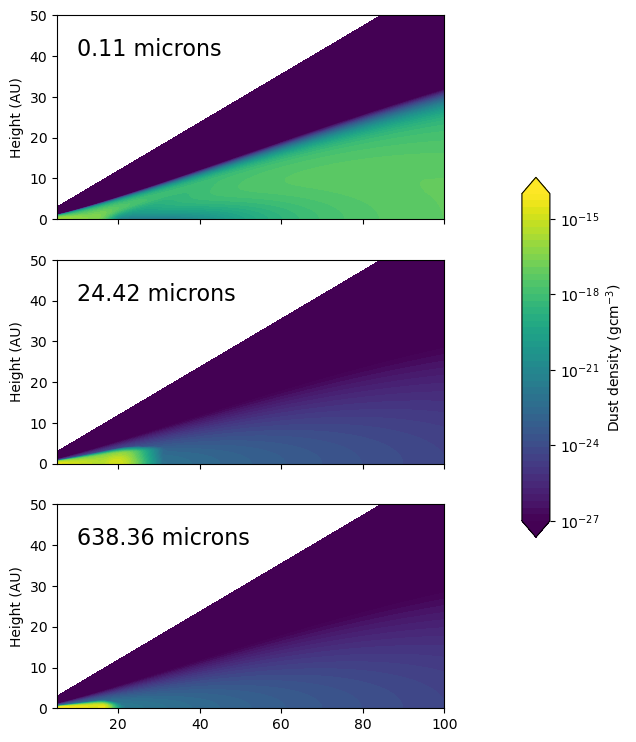

In [2]:
# Plot dust density 

t_snap = -1
grains = [0,50,80]

fig, ax = plt.subplots(len(grains), 1, figsize=(7, 3*len(grains)), sharex=True, sharey=True)

for i in range(len(grains)):
    ax[i].set_aspect("equal")
    con = ax[i].contourf(g.R/au, g.Z/au, np.log10(dust.rho[t_snap,:,:,grains[i]]), np.linspace(-27,-14,50), extend='both')
    #ax[i].quiver(g.R[::10,:100:10]/au, g.Z[::10,:100:10]/au, (dust.vR[t_snap,::10,:100:10,grains[i]]), (dust.vZ[t_snap,::10,:100:10,grains[i]]), color='white', scale=1000)
    ax[i].text(10,40, "%1.2f microns"%(sizes.a_c[grains[i]]*1e4), fontsize=16, c='k')
    ax[i].set_ylabel('Height (AU)')


plt.xlim(5,100)
plt.ylim(0,50)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.04, 0.4])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.set_ticks(np.arange(-27,-12,3))
cbar.set_ticklabels(["$10^{%d}$"%(x) for x in np.arange(-27,-12,3)])
cbar.set_label(r"Dust density (gcm$^{-3}$)")

plt.show()


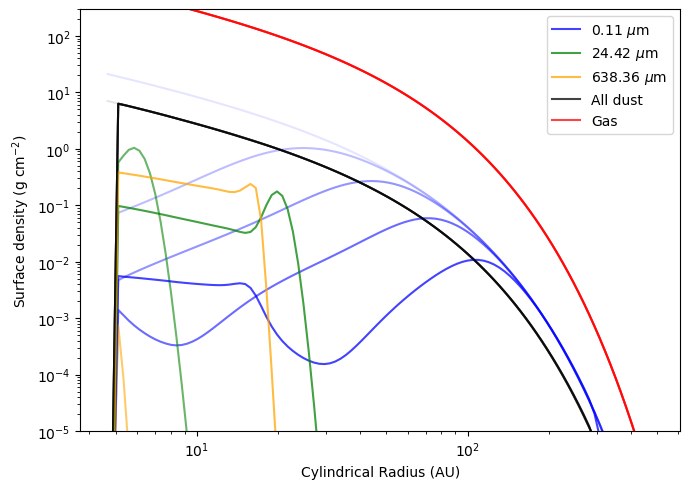

In [3]:
# Calculate and plot dust & gas surface density

def calc_sig_dust(g, dust, sizes):
    sig_d_tot = np.zeros((g.R.shape[0], dust.rho.shape[0]))
    Z_e = g.R_c[:,None] * g.tan_th_e 

    sig_d = 2.*np.sum(sizes.m_c[None,None,None,:] * dust.rho[:,:,2:-2,:] / np.diff(sizes.m_e[None,None,None,:]) * np.diff(Z_e[None,:,2:-2,None],axis=2), axis=2)
    sig_d_tot = 2.*np.sum(dust.rho[:,:,2:-2,:].sum(-1) * np.diff(Z_e[None,:,2:-2]), axis=2)

    return sig_d, sig_d_tot

sig_d, Sig_d = calc_sig_dust(g, dust, sizes)

plt.figure(figsize=(7,5))
for i in range(sig_d.shape[0]):
    if i==sig_d.shape[0]-1:
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[0]], color='b', label="%1.2f $\mu$m"%(1e4*sizes.a_c[grains[0]]),alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[1]], color='g', label="%1.2f $\mu$m"%(1e4*sizes.a_c[grains[1]]),alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[2]], color='orange', label="%1.2f $\mu$m"%(1e4*sizes.a_c[grains[2]]),alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, Sig_d[i,:], color='black', label="All dust",alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, gas.Sigma[i,:], color='r', label="Gas",alpha=0.1+i*0.8/sig_d.shape[0])
    else:
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[0]], color='b',alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[1]], color='g',alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, sig_d[i,:,grains[2]], color='orange',alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, Sig_d[i,:], color='black',alpha=0.1+i*0.8/sig_d.shape[0])
        plt.loglog(g.R[:,0]/au, gas.Sigma[i,:], color='r',alpha=0.1+i*0.8/sig_d.shape[0])

plt.ylim(1e-5, 300)

#plt.xlim(3,19)
plt.ylabel(r"Surface density (g cm$^{-2}$)")
plt.xlabel('Cylindrical Radius (AU)')
plt.legend()
plt.tight_layout()
plt.show()


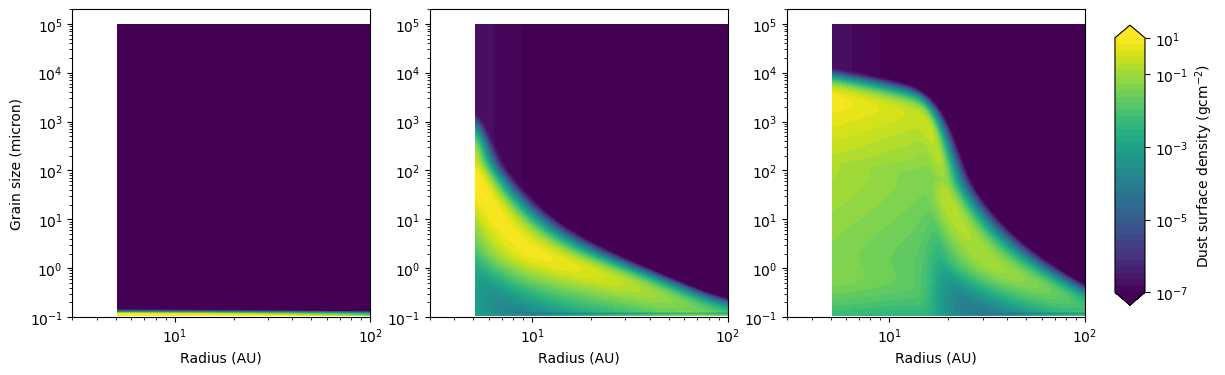

In [4]:
# Plot grain size distribution

R_a_grid, a_R_grid = np.meshgrid(g.R_c[2:-2], sizes.a_c, indexing='ij')

t_snaps = [0,-2,-1]

fig, ax = plt.subplots(1, len(t_snaps), figsize = (5*len(t_snaps),4), sharex=True)

for i, ti in enumerate(t_snaps):
    con = ax[i].contourf(R_a_grid/au, a_R_grid*1e4, np.log10(sig_d[ti,2:-2,:]+1e-100),np.linspace(-7,0,40), extend='both')
    ax[i].set_xlabel("Radius (AU)")
    ax[i].set_ylim(1e-1,2e5)
    ax[i].set_yscale('log')

ax[0].set_ylabel("Grain size (micron)")
plt.xscale('log')

plt.xlim(3,100)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.14, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.set_ticks(np.arange(-7,2,2))
cbar.set_ticklabels(["$10^{%d}$"%(x) for x in np.arange(-7,2,2)])
cbar.set_label(r"Dust surface density (gcm$^{-2}$)")

plt.show()
    

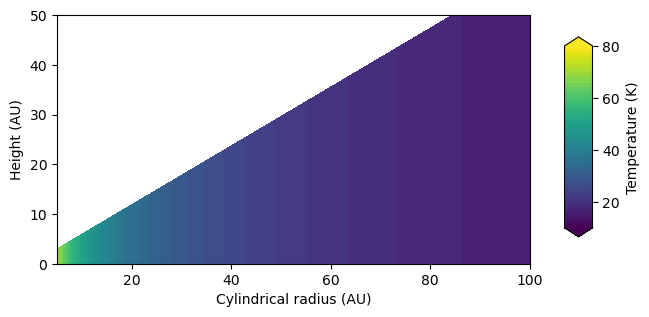

In [13]:
# Plot temperature 

t_snap = 0

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.set_aspect("equal")
con = ax.contourf(g.R/au, g.Z/au, temp.T[t_snap,:,:], np.linspace(10,80,50), extend='both')
ax.set_xlabel('Cylindrical radius (AU)')
ax.set_ylabel('Height (AU)')

plt.xlim(5,100)
plt.ylim(0,50)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.04, 0.4])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.set_ticks(np.arange(20,100,20))
cbar.set_label("Temperature (K)")

plt.show()
